# Telecom Customer Churn Prediction

## Overview 
This project focuses on predicting customer churn for a telecommunications company in California (Q2 2022).  
Customer churn prediction is a key business problem because retaining an existing customer is often cheaper than acquiring a new one.

The objectives of this notebook are to:

- Perform data cleaning and preprocessing on a real-world churn dataset
- Explore key churn-related patterns through EDA
- Build and compare multiple classification models:
  - Logistic Regression
  - Random Forest
  - XGBoost
- Evaluate models using robust metrics such as **ROC-AUC**, **F1-score**, and **confusion matrix**
- Tune decision thresholds to improve churn detection performance

## Dataset Description

This dataset contains **2 CSV tables**:

### **Customer Churn Table**
- Contains information on **7,043 customers** from a Telecommunications company in California in **Q2 2022**
- Each row represents one customer
- Includes:
  - Demographics (e.g., gender, age, dependents)
  - Location information (e.g., city, zip code, latitude/longitude)
  - Subscription services (e.g., Internet type, streaming, security)
  - Billing and contract information
  - Customer status for the quarter (**Joined / Stayed / Churned**)

### **Zip Code Population Table**
- Contains estimated **population values** for zip codes in California
- Can be merged with the churn table using **Zip Code**


## 1. Environment Setup

In [377]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint, uniform
from xgboost import XGBClassifier


## 2. Load Data & Initial Inspection

In [378]:
df = pd.read_csv("dataset/telecom_customer_churn.csv")
df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [379]:
print(f"This dataset contains: {df.shape[0]} customers and {df.shape[1]} features.")
print("List of features:")
print(df.columns)

This dataset contains: 7043 customers and 38 features.
List of features:
Index(['Customer ID', 'Gender', 'Age', 'Married', 'Number of Dependents',
       'City', 'Zip Code', 'Latitude', 'Longitude', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status', 'Churn Category', 'Churn Reason'],
      dtype='object')


In [380]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              3166 non-null   objec

## Missing Values Handling

We can observe that several columns contain **missing values**, particularly those related to optional services and usage metrics.  

Before imputing, we confirm patterns such as:

- `Multiple Lines` is only relevant when `Phone Service = Yes`
- Internet add-ons (e.g., Online Security, Streaming TV) are only relevant when `Internet Service = Yes`



In [381]:
print(pd.crosstab(df["Phone Service"], df["Multiple Lines"], dropna=False))
print()
print(pd.crosstab(
    df["Internet Service"],
    df["Avg Monthly GB Download"].isna(),
    colnames=["Avg Monthly GB Download Is Missing?"]
))

Multiple Lines    No   Yes  NaN
Phone Service                  
No                 0     0  682
Yes             3390  2971    0

Avg Monthly GB Download Is Missing?  False  True 
Internet Service                                 
No                                       0   1526
Yes                                   5517      0


In [382]:
internet_addons = [
    "Online Security", "Online Backup", "Device Protection Plan",
    "Premium Tech Support", "Streaming TV", "Streaming Movies",
    "Streaming Music", "Unlimited Data", "Internet Type"
]

missing_rate = (
    df[internet_addons]
    .isna()
    .groupby(df["Internet Service"])
    .mean()
    .T
)

missing_rate.columns = [f"Missing Rate (Internet Service={c})" for c in missing_rate.columns]
missing_rate


,Missing Rate (Internet Service=No),Missing Rate (Internet Service=Yes)
Online Security,1.0,0.0
Online Backup,1.0,0.0
Device Protection Plan,1.0,0.0
Premium Tech Support,1.0,0.0
Streaming TV,1.0,0.0
Streaming Movies,1.0,0.0
Streaming Music,1.0,0.0
Unlimited Data,1.0,0.0
Internet Type,1.0,0.0


Based on the results, we apply **domain-informed imputation rules** to ensure the dataset remains complete for modeling.

- **Categorical service-related fields** (e.g., *Offer*, *Multiple Lines*, *Internet Type*, and various internet add-ons) will be filled with values such as:
  - `"None"` - when a service category does not apply (e.g. no offer accepted, no internet type)
  - `"No"` - when the customer does not subscribe to the add-on service (e.g. Online Security, Streaming TV)

- **Numeric usage/charge fields** (e.g., *Avg Monthly Long Distance Charges*, *Avg Monthly GB Download*) will be filled with:
  - `0` - representing no usage or no applicable service activity

This approach preserves as much information as possible while ensuring the data remains consistent and fully usable for downstream preprocessing, feature encoding, and machine learning model training.

In [383]:
df["Offer"] = df["Offer"].fillna("None")
df["Avg Monthly Long Distance Charges"] = df["Avg Monthly Long Distance Charges"].fillna(0)
df["Multiple Lines"] = df["Multiple Lines"].fillna("No")
df["Internet Type"] = df["Internet Type"].fillna("None")
df["Avg Monthly GB Download"] = df["Avg Monthly GB Download"].fillna(0)

for col in internet_addons:
    df[col] = df[col].fillna("No")

## 3. Explanatory Data Analysis (EDA)

### Distribution of Numerical Features

We first visualize the distribution of numerical variables using histograms.  

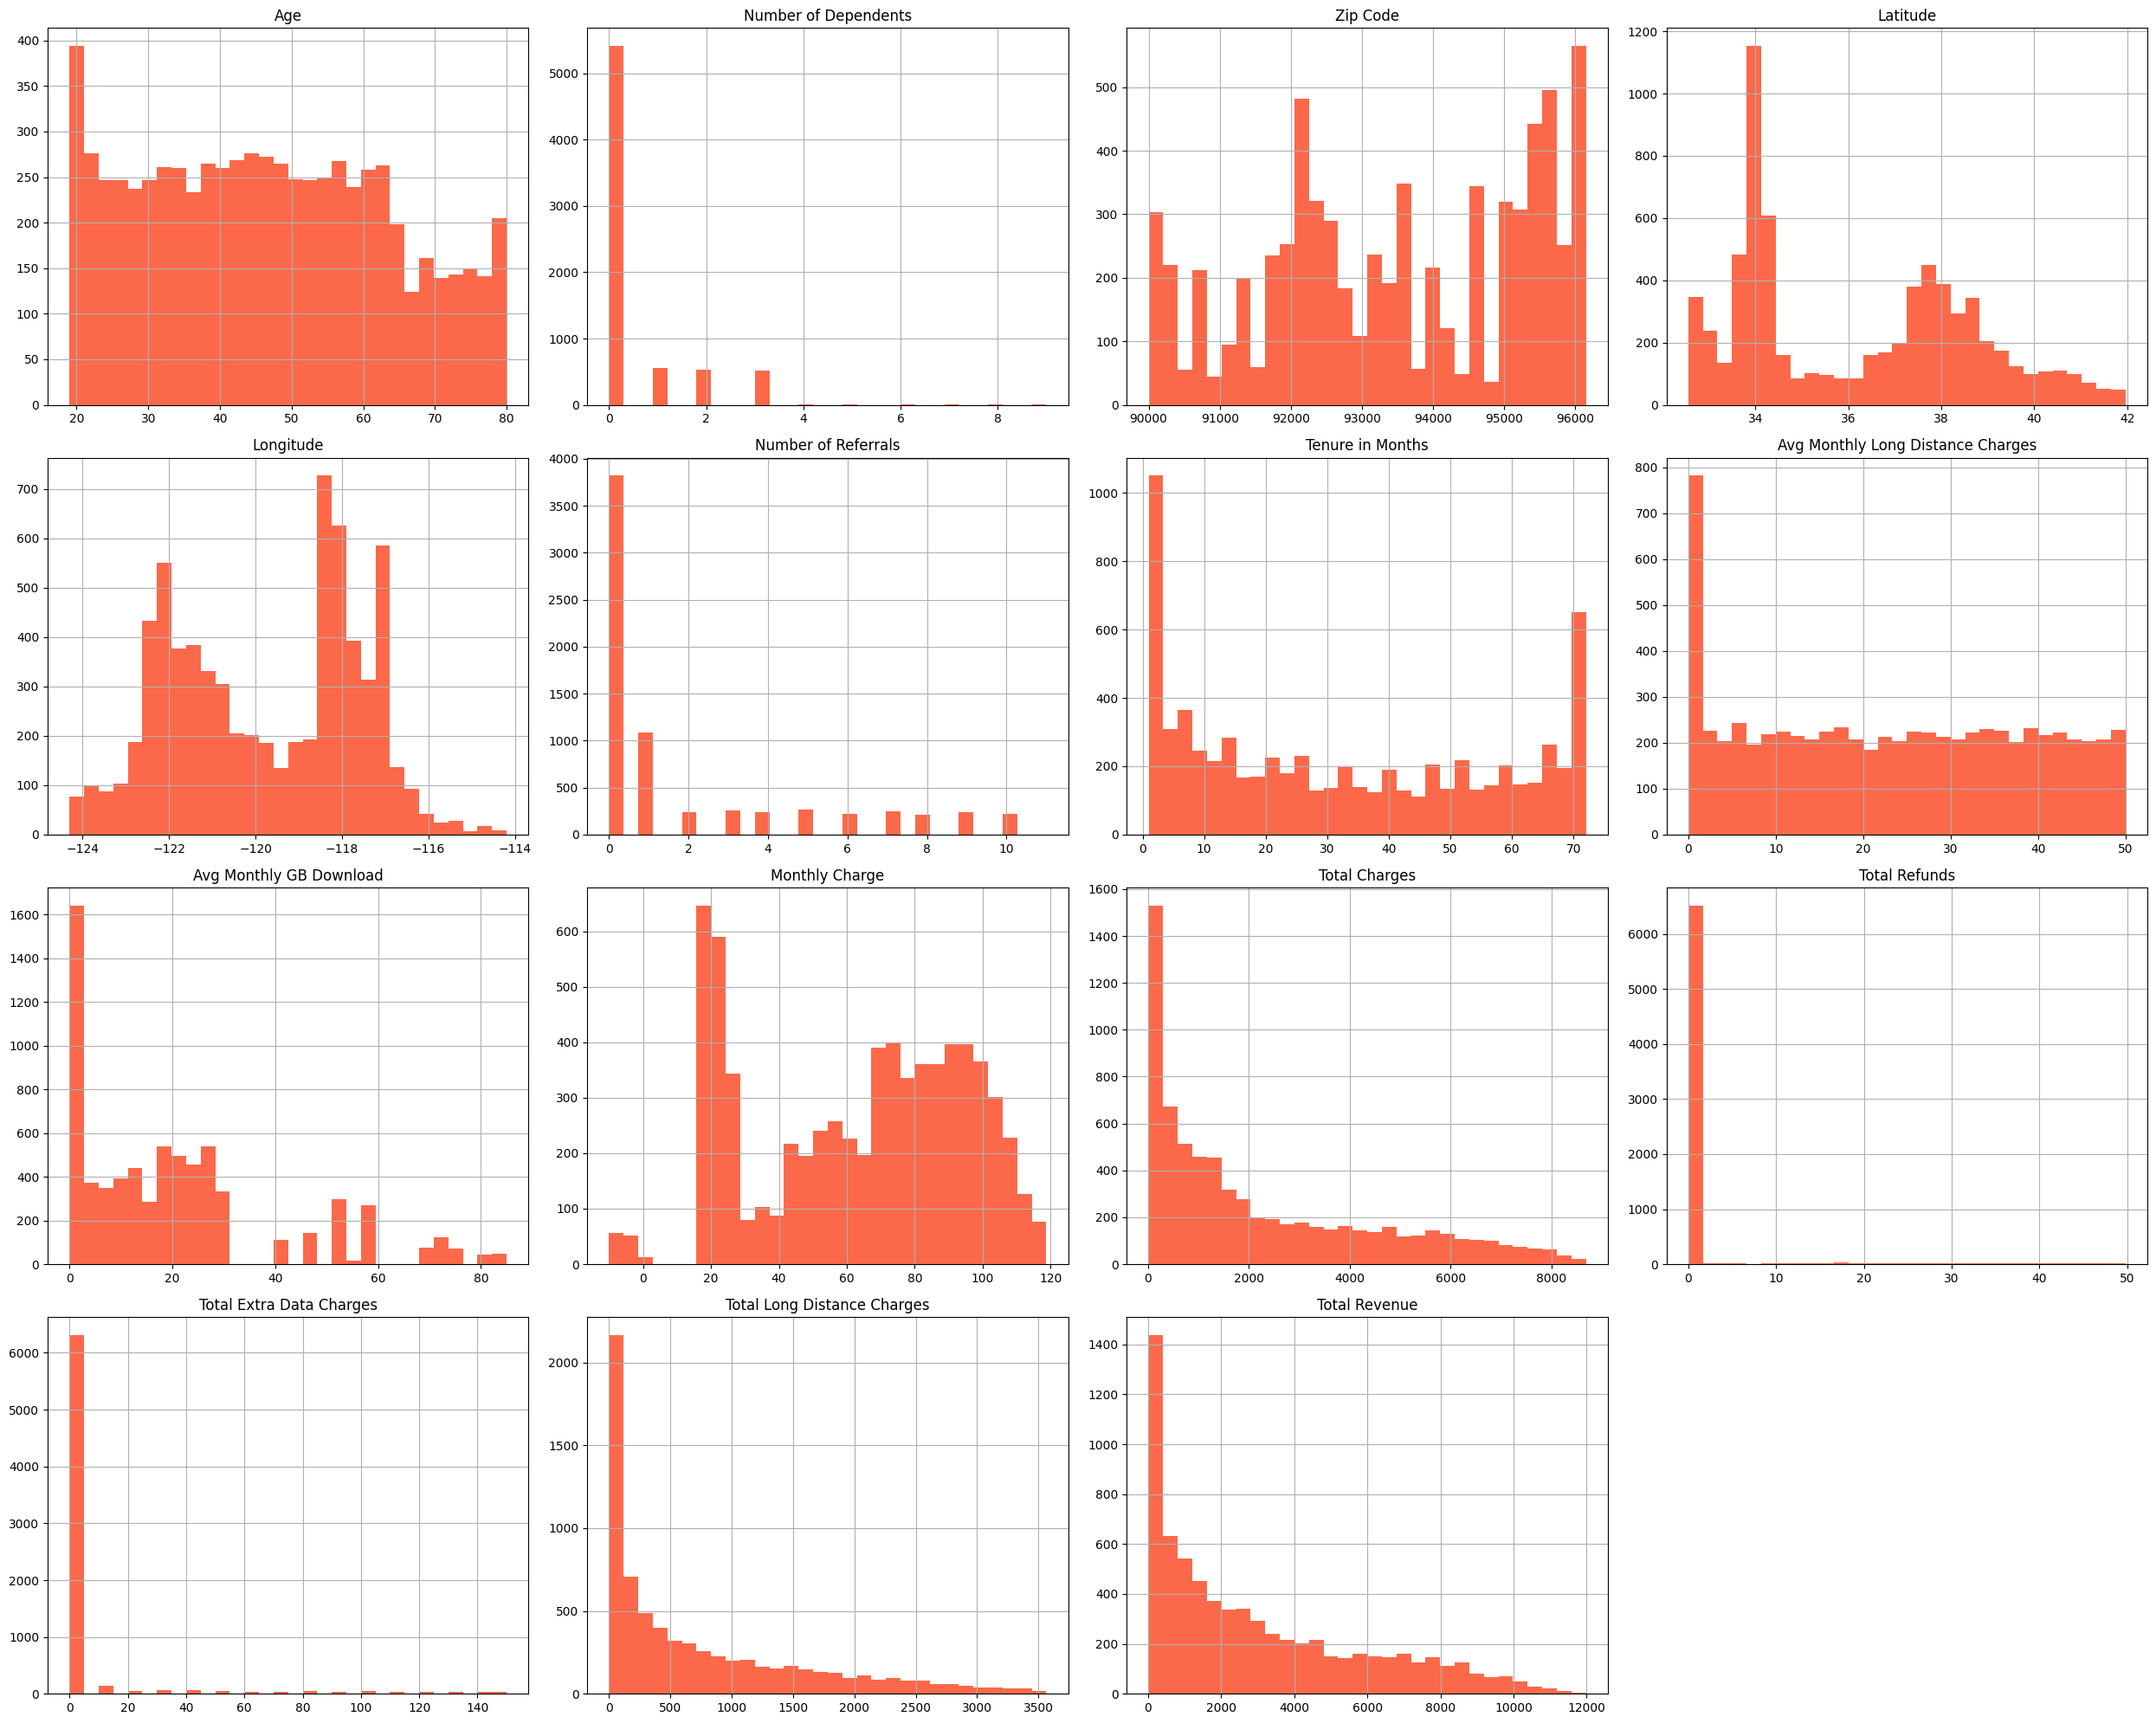

In [384]:
df.hist(
    bins=30,
    figsize=(25, 20), 
    color=sns.color_palette("Reds", 1)
)
plt.tight_layout()
plt.show()


From the numerical feature distributions, we notice several consistent patterns:

- **Tenure in Months** has a wide spread, with a concentration at lower tenures, suggesting many customers are relatively new.
- **Total Charges / Total Revenue** show strong right-skewness, as expected for accumulated billing variables.
- **Total Refunds** and **Total Extra Data Charges** are heavily concentrated near zero, meaning most customers do not frequently receive refunds or incur extra charges.

These findings are aligned with typical telecom churn datasets and motivate further analysis of churn relationships.

### Distribution of Categorical Features

Next, we visualize the distribution of key categorical features using count plots.

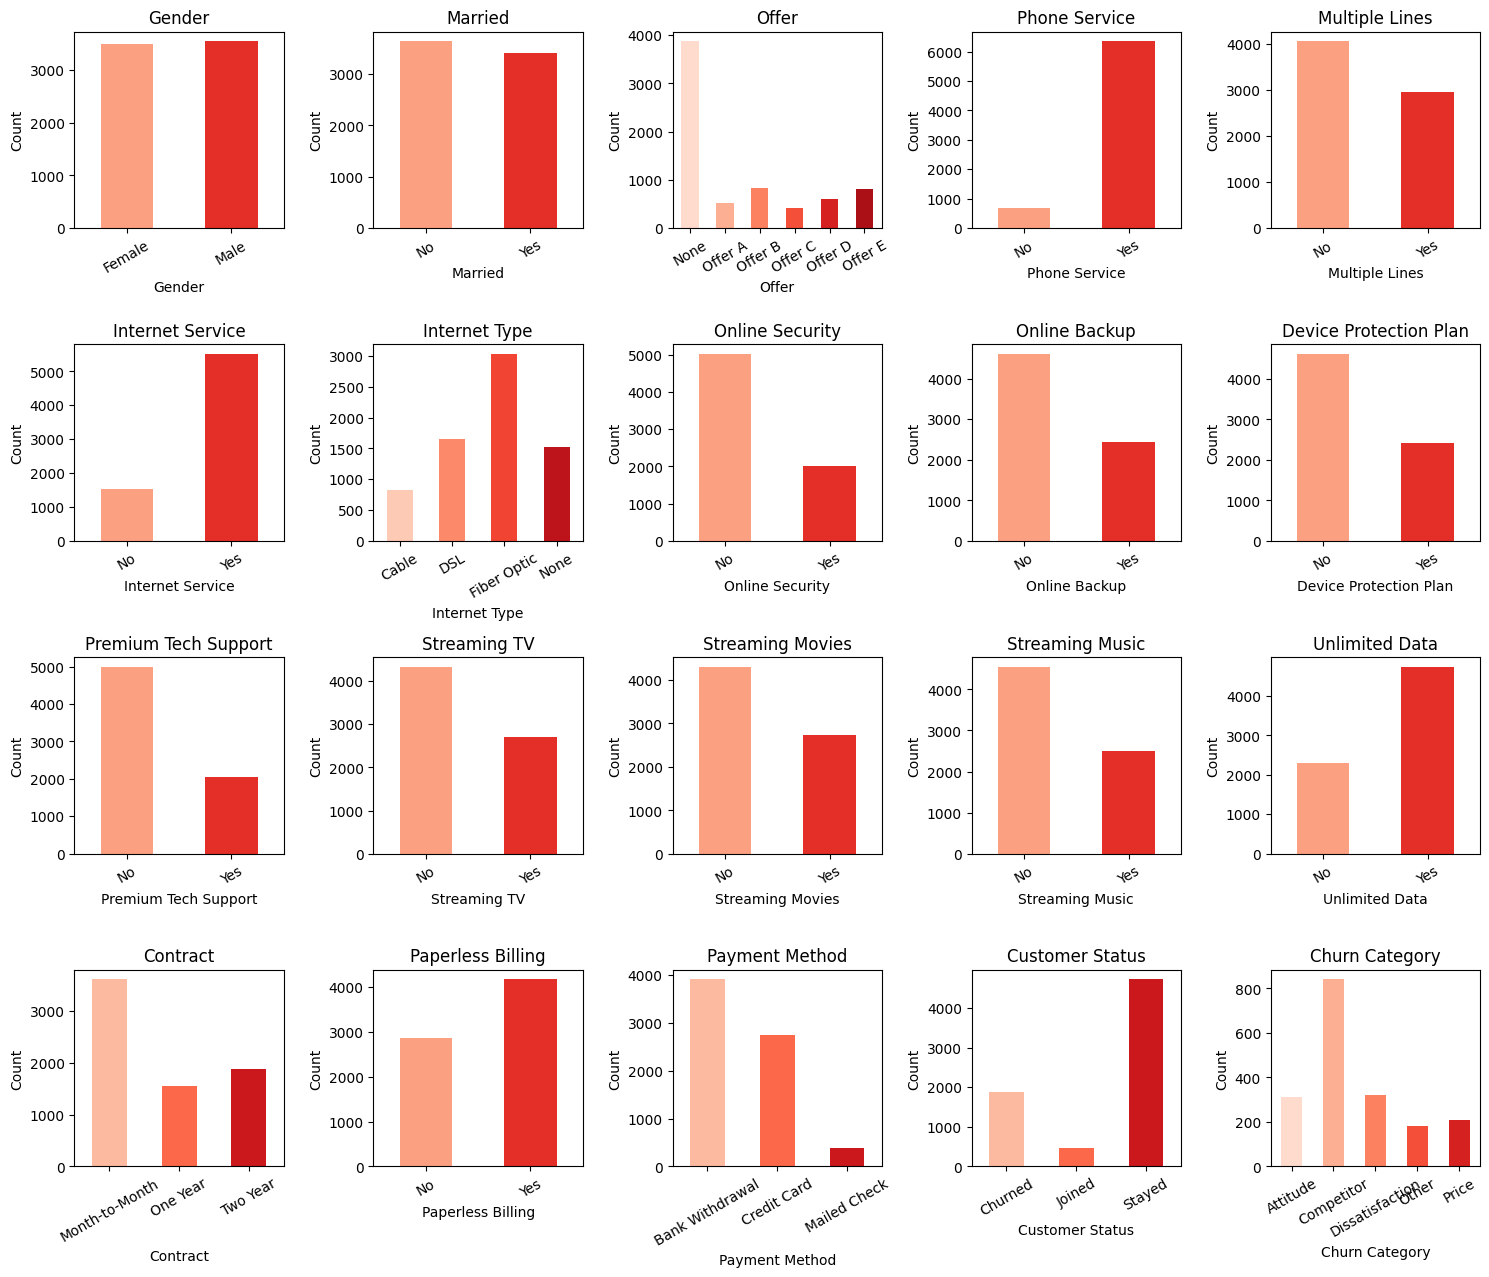

In [385]:
cat_cols = df.drop(columns = ["Customer ID", "City", "Churn Reason"]).select_dtypes(include="object").columns

ncols = 4
nrows = math.ceil(len(cat_cols) / ncols)

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    df[col].value_counts().sort_index().plot(
        kind="bar",
        ax=axes[i],
        color=sns.color_palette("Reds", len(df[col].unique()))
    )

    axes[i].set_title(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis="x", rotation=30)

# remove unused plots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Several high-level patterns can be observed from the categorical distributions:

- **Month-to-month contracts** form the largest group.
- A large portion of customers have **Internet Service enabled**, with **Fiber Optic** appearing as a dominant internet type.
- Most internet add-on services (e.g., Online Security, Backup, Premium Tech Support) show higher counts for **"No"**, indicating add-ons are not widely adopted.
- **Paperless Billing** and **Bank Withdrawal/Credit Card payments** dominate customer billing behavior.

These patterns provide strong candidates for churn-related feature importance in later modeling stages.


## Churn Reasons

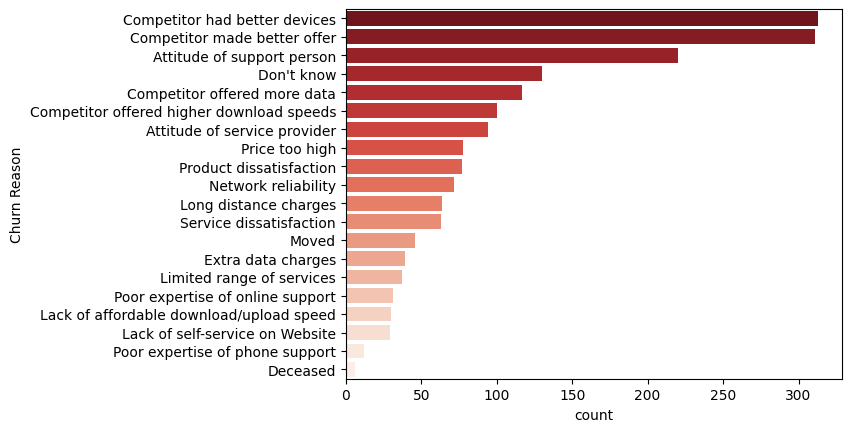

In [386]:
sns.countplot(
    data=df,
    y="Churn Reason",
    order=df["Churn Reason"].value_counts().index,
    palette="Reds_r"
)
plt.show()


The churn reason distribution shows that customers leave for different reasons. Many of them leave because of competitors, which means churn is not only caused by company problems but also by strong competition in the market.

Some common reasons:
- Competitors offering better deals or better devices  
- Bad customer support or service experience  
- Customers being unhappy with prices  
- Network problems or not liking the product  

These results suggest some ways to reduce churn, such as giving special offers to customers who might leave, improving customer service, and creating loyalty programs to keep customers interested.


### Customer Status 

The dataset defines **Customer Status** using three categories:

- **Joined**
- **Stayed**
- **Churned**

We first analyse what **Joined** means by visualizing the distribution of **Tenure in Months** for customers labeled as **Joined**.

<Axes: xlabel='Tenure in Months', ylabel='count'>

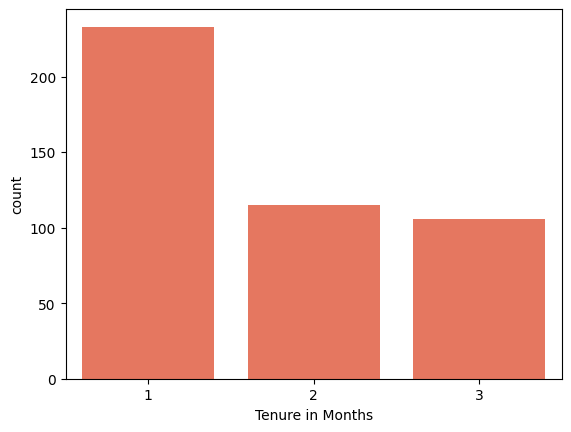

In [387]:
sns.countplot(df[df["Customer Status"] == "Joined"], x="Tenure in Months", color=sns.color_palette("Reds", 1)[0])

The tenure plot shows that customers marked as **Joined** are mostly very new customers (**less than 3 months tenure**).  
So this group is not the same as normal long-term customers.

If we keep them, it may cause bias because:
- They don't have much billing and usage history yet
- Their behaviour is different from existing customers
- The model might learn patterns for new customers instead of predicting churn for current customers

So, to make the churn prediction more fair and realistic, we **drop "Joined" customers** and create a binary target:

- `Churn = 1` → Churned  
- `Churn = 0` → Stayed  


Customer Status
Stayed     0.670169
Churned    0.265370
Joined     0.064461
Name: proportion, dtype: float64
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


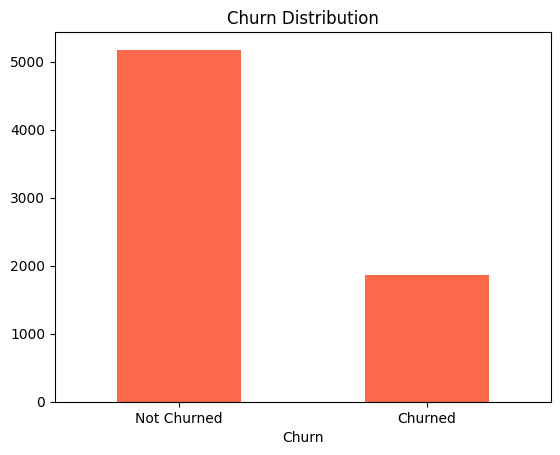

In [388]:
print(df["Customer Status"].value_counts(normalize=True))

df["Churn"] = df["Customer Status"].apply(lambda x: 1 if x == "Churned" else 0)

print(df["Churn"].value_counts(normalize=True))

df["Churn"].value_counts().plot(kind="bar", color=sns.color_palette("Reds", 1))
plt.title("Churn Distribution")
plt.xticks(rotation=0)
plt.gca().set_xticklabels(["Not Churned", "Churned"])
plt.show()

### Relationship Between Features and Churn Rate

Here we check how churn rate changes across different customer groups (e.g. contract type, internet type, payment method).  
This helps us quickly see which categories are linked to higher churn.



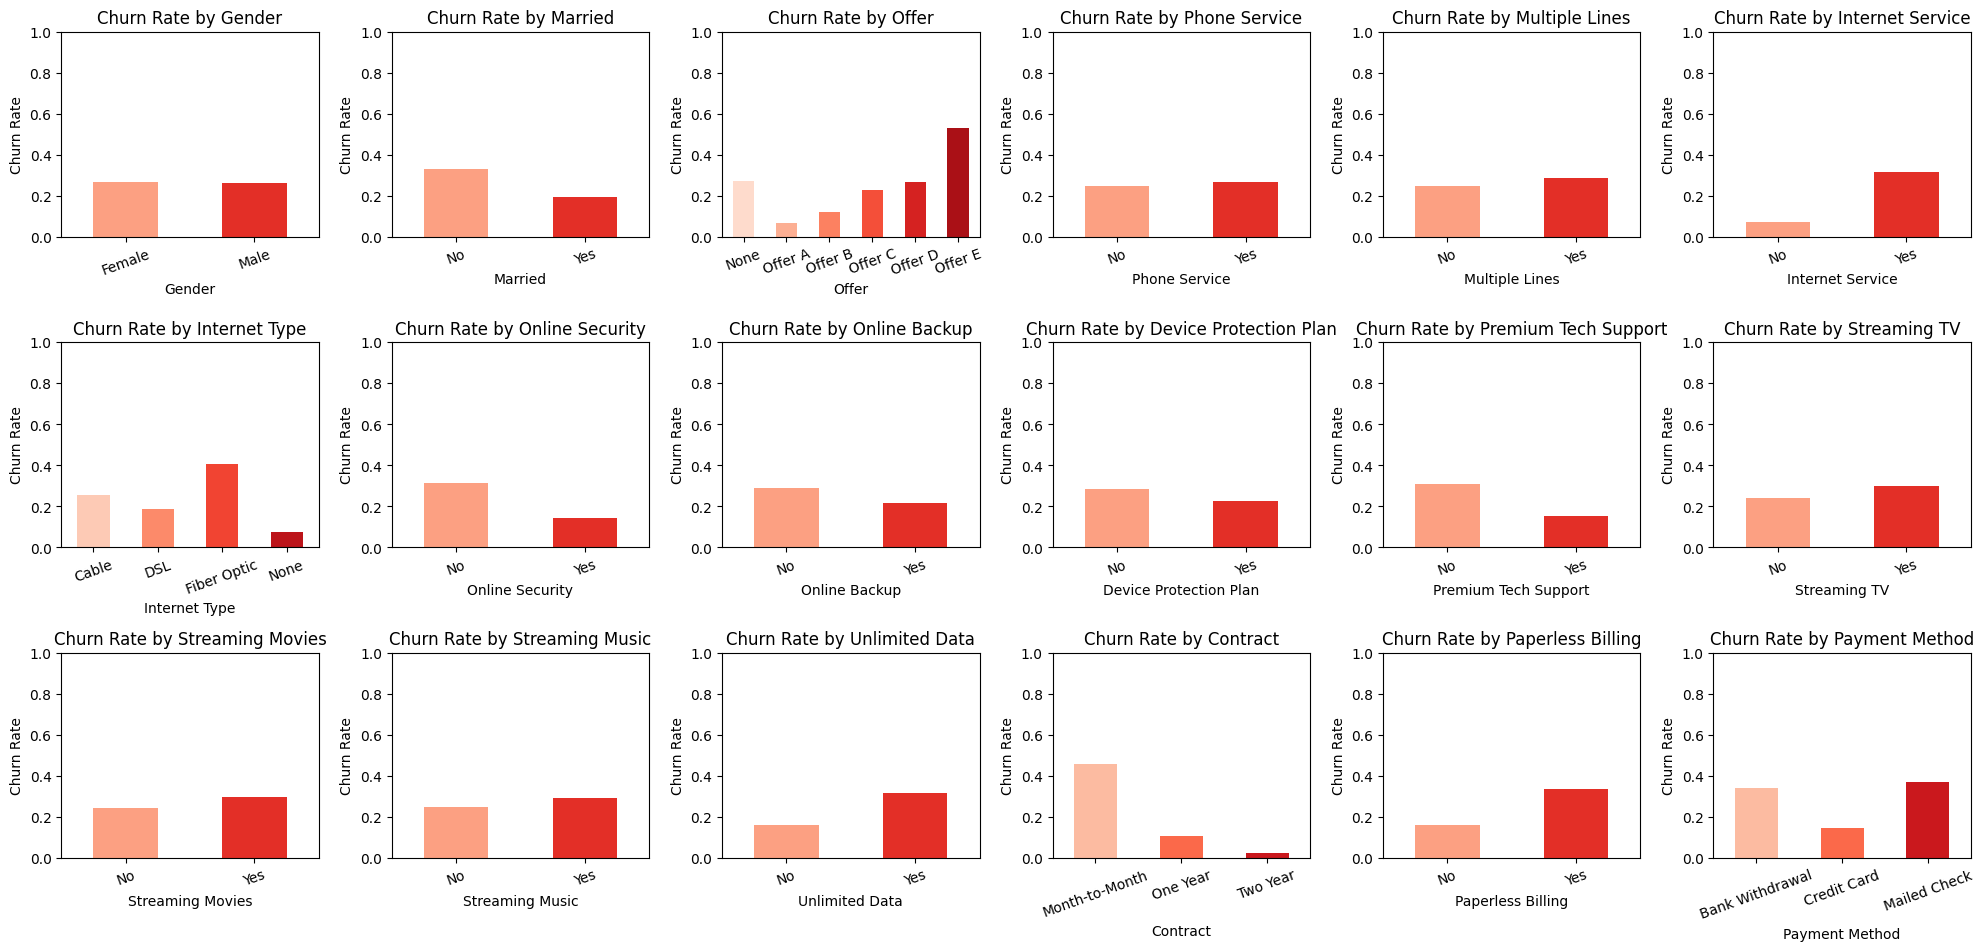

In [389]:
cat_cols = list(df.drop(columns=["Customer ID", "City", "Zip Code", "Latitude", "Longitude", "Churn Reason", "Customer Status", "Churn Category"]).select_dtypes(include="object").columns)



fig, axes = plt.subplots(5, 6, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    churn_rate = df.groupby(col)["Churn"].mean().sort_index()
    palette = sns.color_palette("Reds", len(churn_rate))

    churn_rate.plot(kind="bar", ax=axes[i], color=palette)

    axes[i].set_title(f"Churn Rate by {col}")
    axes[i].set_ylabel("Churn Rate")
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis="x", rotation=20)

# remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
selected_features = [
    "Contract", "Offer",
    "Monthly Charge", "Internet Type",
    "Online Security", "Premium Tech Support",
    "Unlimited Data", "Online Backup", "Device Protection Plan",
    "Paperless Billing", "Payment Method"
]

Quick Insights:

- **Month-to-month** customers churn the most.
- **Fiber Optic** users have higher churn than DSL / no internet.
- Customers without **security/backup/tech support** add-ons churn more.
- **Paperless billing** and some **payment methods** also show higher churn.

Next, we compare numeric features between churned and non-churned customers using boxplots.


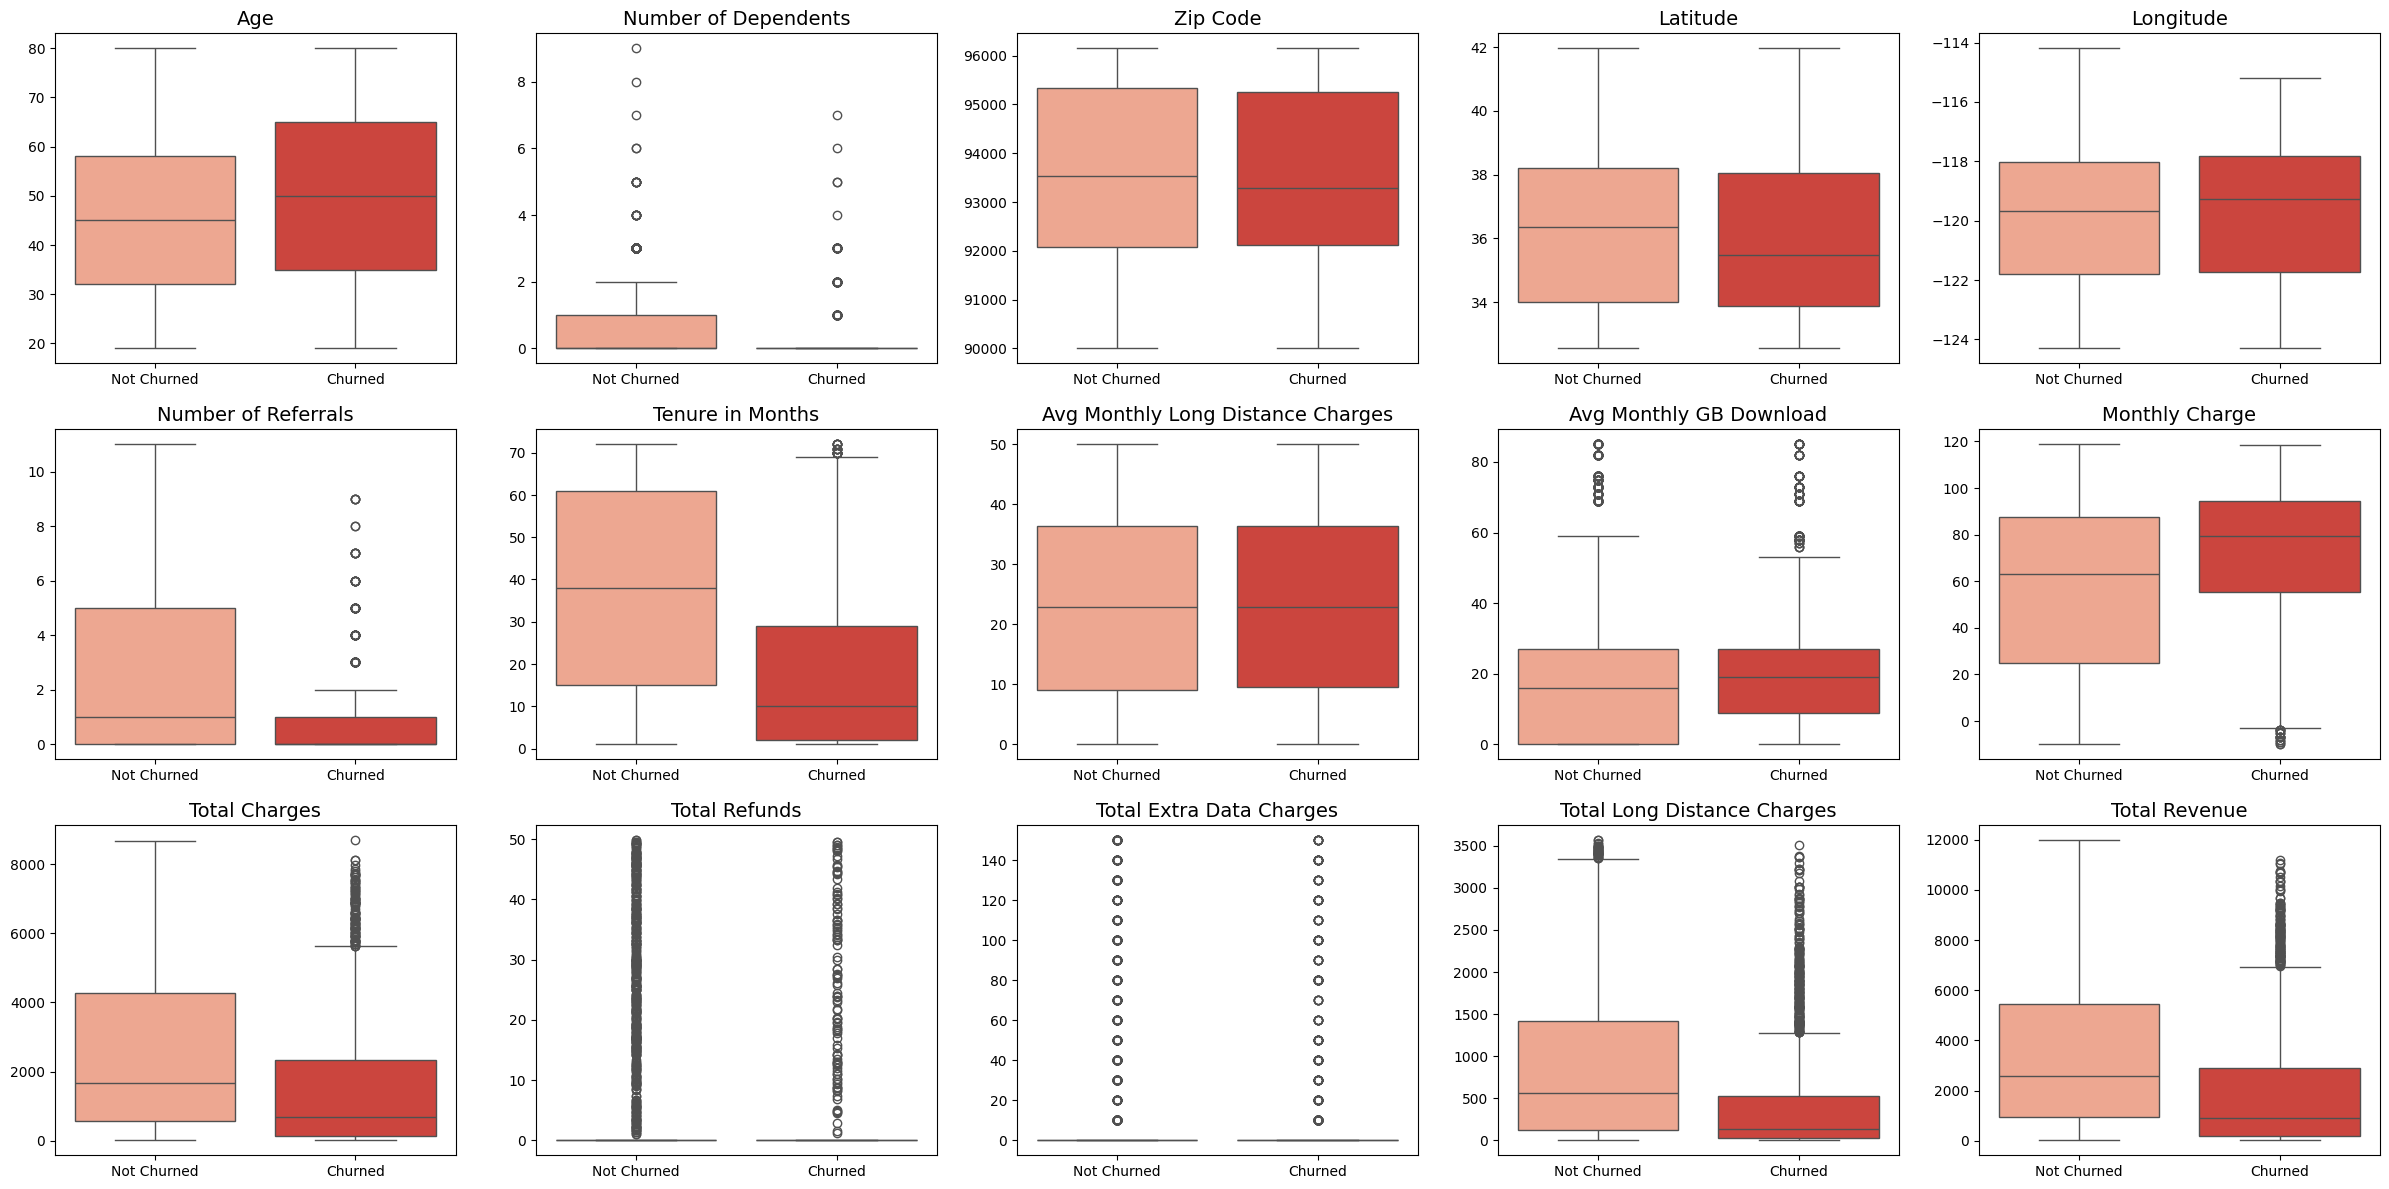

In [390]:
num_cols = [
    cname for cname in df.columns
    if df[cname].dtype in ["int64", "float64"]
    and cname != "Churn"
    and df[cname].nunique() > 2
]

fig, axes = plt.subplots(6, 5, figsize=(30, 30))
axes = axes.flatten()
color_palette = sns.color_palette("Reds", 2)
palette = {"0": color_palette[0], "1": color_palette[1]}

for i, col in enumerate(num_cols):
    ax = axes[i]

    sns.boxplot(
        data=df,
        x="Churn",
        y=col,
        ax=ax,
        palette=palette
    )

    ax.set_title(col, fontsize=14)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels(["Not Churned", "Churned"])

# remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


Quick Insights

- Churned customers usually have **shorter tenure**, so new users should be our target.
- Churned customers often have **higher monthly charges**.
- Total revenue/charges are lower for churned customers (because they leave earlier).
- Customers with more referrals tend to churn less.


## 4. Model Building


### Encoding Binary Features

Some columns are simple **Yes/No** values (like Phone Service, Online Security, Paperless Billing, etc.).  
To make them usable for machine learning, we convert:

- **Yes → 1**
- **No → 0**

We also encode Gender as:
- **Male → 1**
- **Female → 0**


In [391]:
yes_no_cols = [
    "Married", "Phone Service", "Multiple Lines", "Internet Service",
    "Online Security", "Online Backup", "Device Protection Plan",
    "Premium Tech Support", "Streaming TV", "Streaming Movies",
    "Streaming Music", "Unlimited Data", "Paperless Billing"
]

for col in yes_no_cols:
    df[col] = df[col].map({"Yes": 1, "No": 0})

df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})


## Feature Selection 

We selected a subset of features that showed strong patterns in our EDA and are also **actionable** for business decisions.

We mainly focused on:

- **Contract & Offer**
- **Pricing (Monthly Charge)**
- **Internet Type**
- **Add-on Services** (Online Security, Premium Tech Support, Unlimited Data, Online Backup, Device Protection Plan)
- **Billing & Payment** (Paperless Billing, Payment Method)

We excluded loyalty-style variables such as **Tenure in Months** and **Number of Referrals** in this model to improve interpretability, since they strongly correlate with customer loyalty but are less directly controllable by the business.


In [392]:
# selected_features = [
#     # Loyalty
#     "Tenure in Months", "Number of Referrals",

#     # Contract & billing
#     "Contract", "Paperless Billing", "Payment Method", "Offer",

#     # Pricing
#     "Monthly Charge", "Internet Service", "Internet Type",
#     "Online Security", "Premium Tech Support",
#     "Unlimited Data", "Online Backup", "Device Protection Plan",
# ]

selected_features = [
    "Contract", "Offer",
    "Monthly Charge", "Internet Type",
    "Online Security", "Premium Tech Support",
    "Unlimited Data", "Online Backup", "Device Protection Plan",
    "Paperless Billing", "Payment Method"
]

X = df[selected_features]
y = df["Churn"]



We split the dataset into training and testing sets: **80% training**, **20% testing**

We use `stratify=y` to keep the churn ratio similar in both sets, since churn is slightly imbalanced.


In [393]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


### Pre-Processing
Our dataset contains different feature types:

- **Numerical** (Monthly Charge) → scaled using `StandardScaler`
- **Categorical** (Contract, Payment Method, Internet Type, Offer) → one-hot encoded
- **Binary** (Yes/No columns) → already encoded as 0/1, so we keep them

We put all preprocessing + the model into one `Pipeline`, so the workflow is clean and prevents data leakage

In [394]:
num_cols = [
    "Monthly Charge"
]

cat_cols = [
    "Contract", "Payment Method", "Internet Type", "Offer"
]

bin_cols = [c for c in selected_features if c not in num_cols + cat_cols]

In [395]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop=None, handle_unknown="ignore"), cat_cols),
        ("bin", "passthrough", bin_cols)
    ]
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000))  # better for interpretability
])

### 4.1. Logistic Regression
#### Hyperparameter Tuning (Grid Search)

We used **GridSearchCV (5-fold CV)** to tune Logistic Regression hyperparameters, using **ROC-AUC** as the scoring metric (good for imbalanced datasets like churn).

We test:
- different **C values** (regularization strength)
- **L1 vs L2 penalty**
- using `class_weight="balanced"` vs None

**Note**: We used **ROC-AUC** as the scoring metric here because ROC-AUC measures how well the model can **rank churn customers higher than non-churn customers**, and it does **not depend on a fixed classification threshold** (e.g., 0.5) 
This makes ROC-AUC a reliable metric for comparing different hyperparameter settings during cross-validation, especially for moderately imbalanced datasets like churn.


In [396]:
param_grid = {
    "model__C": [0.01, 0.1, 1, 5, 10],
    "model__penalty": ["l1", "l2"],
    "model__class_weight": [None, "balanced"]
}

gs = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring="roc_auc",  # good for imbalanced data
    cv=5,
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)

print("\nBest parameters:", gs.best_params_)
print("Best CV ROC-AUC:", gs.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'model__C': 1, 'model__class_weight': 'balanced', 'model__penalty': 'l2'}
Best CV ROC-AUC: 0.8564121119158115


From the result, here is our best model:
- **Total fits:** 100 (20 parameter combinations × 5 folds)
- **Best parameters:**
  - `C = 1`
  - `penalty = l2`
  - `class_weight = balanced`
- **Best CV ROC-AUC:** **0.856**

This means our tuned logistic regression model can separate churn vs non-churn fairly well based on the selected features.

After selecting the best model, we evaluate it on the **test set** to check how well it generalizes to unseen data.


### Threshold Tuning
By default, Logistic Regression uses a threshold of **0.5** to classify churn. However, with imbalanced data, **0.5 may miss too many churn cases**.

So we tested thresholds from **0.05 → 0.95** and selected the one with the **highest F1-score**.

**Note**: We use **F1-score** because the final classification decision depends on the chosen probability threshold.  
F1-score balances **precision** and **recall**, which is important in churn prediction: we want to catch churners (high recall) while avoiding too many false alarms (reasonable precision).



In [413]:
best_clf = gs.best_estimator_
y_proba = best_clf.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.05, 0.96, 0.05)

best_t = 0
best_f1 = 0

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("Best threshold for F1:", best_t)
print("Best F1:", best_f1)

y_pred_best = (y_proba >= best_t).astype(int)
print(classification_report(y_test, y_pred_best))

Best threshold for F1: 0.55
Best F1: 0.6496674057649667
              precision    recall  f1-score   support

           0       0.91      0.77      0.84      1035
           1       0.55      0.78      0.65       374

    accuracy                           0.78      1409
   macro avg       0.73      0.78      0.74      1409
weighted avg       0.81      0.78      0.79      1409



This threshold improves churn detection (high recall = 0.80), meaning we catch more churn customers, even though it may predict some extra false churn cases

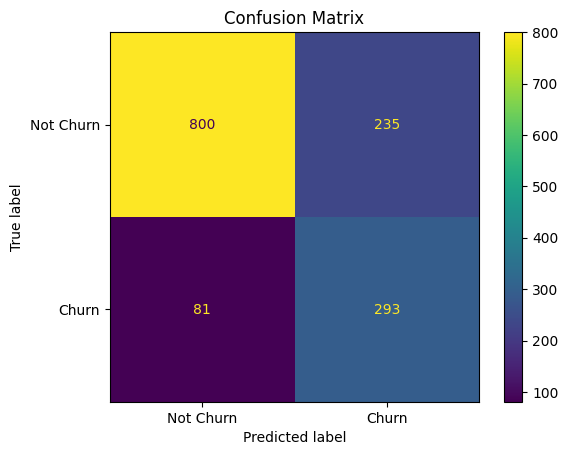

In [414]:
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Churn", "Churn"])
disp.plot(values_format="d")
plt.title("Confusion Matrix")
plt.show()


### Coefficients

After training the Logistic Regression model, we looked at the learned **coefficients** to understand which features increase or decrease churn risk.


In [399]:
feature_names = best_clf.named_steps["preprocess"].get_feature_names_out()
coefficients = best_clf.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

coef_df


,Feature,Coefficient
1,cat__Contract_Month-to-Month,1.356355
16,cat__Offer_Offer E,0.697028
0,num__Monthly Charge,0.448946
6,cat__Payment Method_Mailed Check,0.443521
22,bin__Paperless Billing,0.380449
9,cat__Internet Type_Fiber Optic,0.309359
7,cat__Internet Type_Cable,0.286456
12,cat__Offer_Offer A,0.113028
11,cat__Offer_None,0.071584
8,cat__Internet Type_DSL,-0.006375


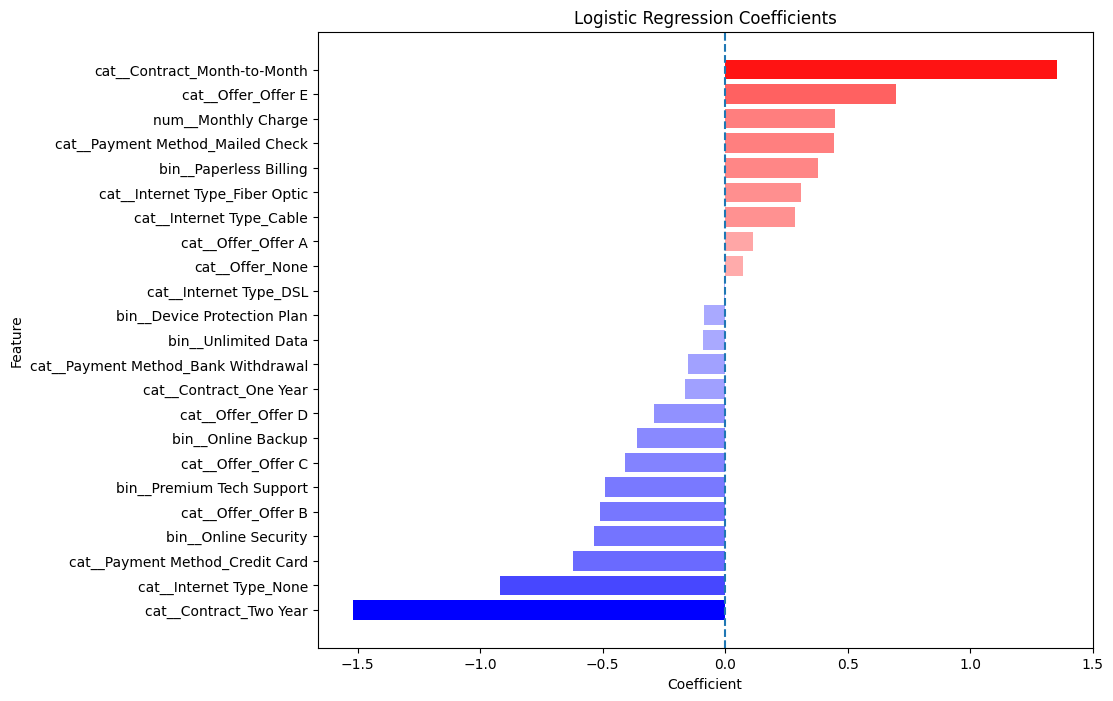

In [400]:
vals = coef_df["Coefficient"].values
abs_vals = np.abs(vals)

norm = plt.Normalize(abs_vals.min(), abs_vals.max())

colors = []
for v in vals:
    intensity = norm(abs(v))
    if v >= 0:
        colors.append(mcolors.to_rgba("red", alpha=0.3 + 0.7 * intensity))
    else:
        colors.append(mcolors.to_rgba("blue", alpha=0.3 + 0.7 * intensity))

plt.figure(figsize=(10, 8))
plt.barh(coef_df["Feature"], coef_df["Coefficient"], color=colors)


plt.axvline(0, linestyle="--")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title(f"Logistic Regression Coefficients")
plt.gca().invert_yaxis()
plt.show()

Overall, the model suggests churn is mainly driven by:
- **Short-term contracts (Month-to-Month)**
- **Higher monthly price**
- **Mailed Check payment method**
- **Certain offer groups (especially Offer E)**

And churn is reduced by:
- **Long-term contracts (Two Year / One Year)**
- **Extra services like Online Security and Premium Tech Support**
- **More stable payment methods (Credit Card / Bank Withdrawal)**

These patterns also match what we observed earlier during EDA.

### 4.2. Random Forests

We also tried a **Random Forest**, which is an ensemble of decision trees that can capture non-linear relationships and feature interactions.

We built a pipeline with:
- **OneHotEncoder** for categorical features (`Contract`, `Payment Method`, `Internet Type`, `Offer`)
- **Passthrough** for numeric + binary features
- **RandomForestClassifier**



In [401]:
preprocess_tree = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("bin_num", "passthrough", bin_cols + num_cols),
    ],
    remainder="drop"
)


### Hyperparameter tuning (RandomizedSearchCV)
We tuned the Random Forest using **RandomizedSearchCV** with:
- `scoring = "roc_auc"`
- `cv = 3`
- `n_iter = 80`


In [402]:
rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ))
])

rf_param_dist = {
    "model__n_estimators": randint(200, 500),         
    "model__max_depth": [None, 6, 10, 14, 18],
    "model__min_samples_split": randint(2, 50),
    "model__min_samples_leaf": randint(1, 30),
    "model__max_features": ["sqrt", "log2", 0.5],
    "model__class_weight": [None, "balanced"]
}

rf_rs = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=80,             
    scoring="roc_auc",
    cv=3,                   
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_rs.fit(X_train, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model__class_weight': [None, 'balanced'], 'model__max_depth': [None, 6, ...], 'model__max_features': ['sqrt', 'log2', ...], 'model__min_samples_leaf': <scipy.stats....t 0x13eff42f0>, ...}"
,n_iter,80
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [403]:
print("Best AUC (CV):", rf_rs.best_score_)
print("Best params:", rf_rs.best_params_)

best_rf = rf_rs.best_estimator_
y_proba = best_rf.predict_proba(X_test)[:, 1]
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))

Best AUC (CV): 0.8552959473986405
Best params: {'model__class_weight': None, 'model__max_depth': 14, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 15, 'model__min_samples_split': 44, 'model__n_estimators': 271}
Test ROC-AUC: 0.8617362887183858


From the result, we found that best parameters would be:
- `n_estimators = 271`
- `max_depth = 14`
- `max_features = sqrt`
- `min_samples_split = 44`
- `min_samples_leaf = 15`
- `class_weight = None`

In [404]:
# # Tune threshold for recall with precision constraint
# y_proba = best_rf.predict_proba(X_test)[:, 1]
# thresholds = np.arange(0.05, 0.95, 0.01)

# min_precision = 0.70  # change to 0.5 if you want more recall

# best_t = 0.5
# best_recall = 0

# for t in thresholds:
#     y_pred_t = (y_proba >= t).astype(int)
#     p = precision_score(y_test, y_pred_t)
#     r = recall_score(y_test, y_pred_t)

#     if p >= min_precision and r > best_recall:
#         best_recall = r
#         best_t = t

# print("Best threshold (Recall-focused):", best_t)
# print("Best recall (Precision >= {:.2f}): {:.3f}".format(min_precision, best_recall))

# y_pred_best = (y_proba >= best_t).astype(int)

# print("\nClassification Report (Best Threshold):")
# print(classification_report(y_test, y_pred_best))

# print(confusion_matrix(y_test, y_pred_best))

Since churn is imbalanced, we tuned the decision threshold to improve our model. We tested thresholds from **0.05 → 0.95** and selected the one with the **highest F1-score**.


In [405]:
y_proba = best_rf.predict_proba(X_test)[:, 1]
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))

thresholds = np.arange(0.05, 0.95, 0.05)

best_t = 0.5
best_f1 = 0

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    score = f1_score(y_test, y_pred_t)
    if score > best_f1:
        best_f1 = score
        best_t = t

print("Best Threshold:", best_t)
print("Best F1:", best_f1)

y_pred_best = (y_proba >= best_t).astype(int)

print("\nClassification Report (Best Threshold):")
print(classification_report(y_test, y_pred_best))

Test ROC-AUC: 0.8617362887183858
Best Threshold: 0.45
Best F1: 0.6520547945205479

Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1035
           1       0.67      0.64      0.65       374

    accuracy                           0.82      1409
   macro avg       0.77      0.76      0.77      1409
weighted avg       0.82      0.82      0.82      1409



This threshold increases recall for churn customers, meaning we catch more real churn cases.


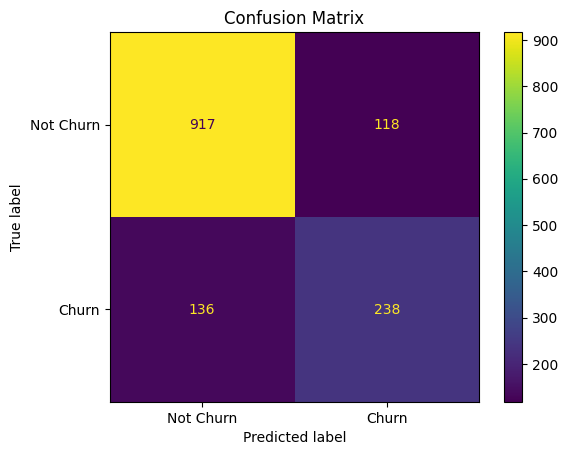

In [406]:
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Churn", "Churn"])
disp.plot(values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [407]:
# get trained RF model from pipeline
rf_model = best_rf.named_steps["model"]

# get feature names AFTER preprocessing (includes one-hot feature names)
feature_names = best_rf.named_steps["preprocess"].get_feature_names_out()

importances = rf_model.feature_importances_

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_imp


,feature,importance
0,cat__Contract_Month-to-Month,0.270576
2,cat__Contract_Two Year,0.142231
22,bin_num__Monthly Charge,0.101258
8,cat__Internet Type_Fiber Optic,0.072297
1,cat__Contract_One Year,0.065959
15,cat__Offer_Offer E,0.044852
9,cat__Internet Type_None,0.043425
17,bin_num__Premium Tech Support,0.042401
16,bin_num__Online Security,0.037471
4,cat__Payment Method_Credit Card,0.036388


Most important features in the Random Forest were:
- **Contract = Month-to-Month** (strongest signal)
- **Monthly Charge**
- **Contract = Two Year / One Year**
- **Offer (especially Offer E)**
- **Internet Type (Fiber Optic)**
- **Online Security / Premium Tech Support**

Overall, these match the trend we saw earlier in EDA: customers with short contracts and higher charges are more likely to churn.

### 4.3. XGBoost


For the final model, we trained **XGBoost**, which is a boosted tree model that builds trees **sequentially**.  
Each new tree focuses more on the mistakes made by the previous trees, so the overall model becomes stronger over time.

### Model setup
We used the same preprocessing pipeline as Random Forest:
- **OneHotEncoder** for categorical features  
- **Pass-through** for binary + numeric features  
- Train/test split kept the same

In [408]:
xgb_pipe = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", XGBClassifier(random_state=42, n_jobs=-1))
])

xgb_pipe.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('bin_num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


We tuned the model using **3-fold cross-validation** with **ROC-AUC** as the scoring metric.


In [409]:
xgb_pipe = Pipeline(steps=[
    ("preprocess", preprocess_tree),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    ))
])

xgb_param_dist = {
    "model__n_estimators": randint(200, 900),
    "model__learning_rate": uniform(0.02, 0.18),   
    "model__max_depth": randint(2, 8),
    "model__min_child_weight": randint(1, 12),
    "model__subsample": uniform(0.6, 0.4),         
    "model__colsample_bytree": uniform(0.6, 0.4), 
    "model__gamma": uniform(0.0, 0.6),
    "model__reg_alpha": uniform(0.0, 0.5),
    "model__reg_lambda": uniform(0.5, 2.0),
}

xgb_rs = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=xgb_param_dist,
    n_iter=50,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

xgb_rs.fit(X_train, y_train)

print("Best CV AUC:", xgb_rs.best_score_)
print("Best params:", xgb_rs.best_params_)
best_xgb = xgb_rs.best_estimator_


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best CV AUC: 0.8594248771720904
Best params: {'model__colsample_bytree': np.float64(0.9906459823330611), 'model__gamma': np.float64(0.24662220799093876), 'model__learning_rate': np.float64(0.02594913192209871), 'model__max_depth': 2, 'model__min_child_weight': 1, 'model__n_estimators': 602, 'model__reg_alpha': np.float64(0.3403527257773834), 'model__reg_lambda': np.float64(1.5618691666342728), 'model__subsample': np.float64(0.7791132658292367)}


In [410]:
y_proba = best_xgb.predict_proba(X_test)[:, 1]
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))

Test ROC-AUC: 0.8633547753752358


Best parameters found:
- `n_estimators = 602`
- `max_depth = 2`
- `learning_rate = 0.0259`
- `subsample = 0.779`
- `colsample_bytree = 0.991`
- `gamma = 0.247`
- `min_child_weight = 1`
- `reg_alpha = 0.340`
- `reg_lambda = 1.562`

As before, we tune our threshold to achieve highest F1-Score


In [411]:
thresholds = np.arange(0.05, 0.95, 0.05)

best_t = 0.5
best_f1 = 0

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    score = f1_score(y_test, y_pred_t)
    if score > best_f1:
        best_f1 = score
        best_t = t

print("Best Threshold:", best_t)
print("Best F1:", best_f1)

Best Threshold: 0.30000000000000004
Best F1: 0.6524184476940382


In [412]:
y_pred_best = (y_proba >= best_t).astype(int)

print("\nClassification Report (Best Threshold):")
print(classification_report(y_test, y_pred_best))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))



Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1035
           1       0.56      0.78      0.65       374

    accuracy                           0.78      1409
   macro avg       0.73      0.78      0.75      1409
weighted avg       0.82      0.78      0.79      1409


Confusion Matrix:
[[810 225]
 [ 84 290]]
